In [234]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numba import jit, int32, float32, types, typed
from numba.typed import List
from numba.experimental import jitclass

In [274]:
spec = [
    ('free_mean_path_para', float32), # a simple scalar field
    ('free_mean_path_perp', float32), 
    ('gyro_radius', float32), 
    ('t', float32),
    ('pos', float32[:]),          # an array field
    ('direction', types.ListType(types.int64))     
]

@jitclass(spec)
class particle():
    def __init__(self, gyro_radius, free_mean_path_para, free_mean_path_perp, direction):
        self.gyro_radius = gyro_radius
        self.free_mean_path_para = free_mean_path_para
        self.free_mean_path_perp = free_mean_path_perp
        self.t = 0
        self.pos = np.zeros(3, dtype=np.float32)
        self.direction = direction
                 
     
    def move(self, step_size):
        p = 1.0*step_size
        self.t = self.t + 1*step_size
        
        if self.t > self.gyro_radius:
            # after gyroradius ~ half gyroorbit, particle 
            # needs to change direction perp to background field
            if (random.randint(0, self.free_mean_path_perp) == 1):
                self.direction[0] = self.direction[0]*(-1)
            if (random.randint(0, self.free_mean_path_perp) == 0):
                self.direction[1] = self.direction[1]*(-1)
        if self.t > self.free_mean_path_para:
            # after mean-free length, particle can also change 
            # direction parallel to mean field
            if (random.randint(0, self.free_mean_path_para) == 0):
                self.direction[2] = self.direction[2]*(-1)
            
        absDirection = (self.direction[0]**2+self.direction[1]**2+self.direction[2]**2)**0.5
        self.pos[0] = self.pos[0] + p*self.direction[0]/absDirection
        self.pos[1] = self.pos[1] + p*self.direction[1]/absDirection
        self.pos[2] = self.pos[2] + p*self.direction[2]/absDirection
        
    def kappa(self, axis):
        return self.pos[axis]**2/(2*self.t)

In [319]:
steps = 10**5
t_max = 10**5
time = np.linspace(1, t_max, steps)
step = t_max / steps
old_time = 0
nr_particles = 2000

gyro_radius = 30
free_mean_path_para = 200
free_mean_path_perp = 10

In [320]:
# generate particles
@jit(nopython=True)
def source():
    particles = List()
    for j in range(nr_particles):
        direction = List()
        random_values = np.random.randint(low=0, high=1, size=3)*2-1
        [direction.append(x) for x in random_values]
        particles.append(particle(gyro_radius, free_mean_path_para, free_mean_path_perp, direction))
    return particles
    

@jit(nopython=True)
def run_simulation(particles, time):
    kappa_perp = []
    kappa_para = []
    x = [0]
    y = [0]
    for i, t in enumerate(time):
        kappa_perp_sum = 0
        kappa_para_sum = 0
        for p in particles:
            p.move(step)
            kappa_perp_sum = kappa_perp_sum + (p.kappa(0)+p.kappa(1))/2
            kappa_para_sum = kappa_para_sum + p.kappa(2)
            if i == len(time)-1:
                x.append(p.pos[0])
                y.append(p.pos[1])
        
        kappa_para.append(kappa_para_sum/len(particles))
        kappa_perp.append(kappa_perp_sum/len(particles))

    return [kappa_para, kappa_perp, x, y]

In [327]:
%time data = run_simulation(source(), time)

CPU times: user 36.9 s, sys: 99.7 ms, total: 37 s
Wall time: 36.8 s


In [321]:
data = run_simulation(source(), time)
kappa_para = data[0]
kappa_perp = data[1]
x = data[2]
y = data[3]

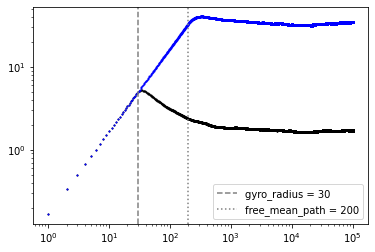

In [322]:
plt.scatter(time, kappa_perp, c='k', s=1)
#plt.scatter(range(1,n), kappa_y, c='r')
plt.scatter(time, kappa_para, c='b', s=1)
plt.axvline(x=gyro_radius, color = 'grey', ls='--', label='gyro_radius = '+str(gyro_radius))
plt.axvline(x=free_mean_path_para, color = 'grey', ls=':', label='free_mean_path = '+str(free_mean_path_para))
plt.xscale('log')
plt.yscale('log')
plt.legend('$d$ [pc]')
plt.legend()
plt.show()

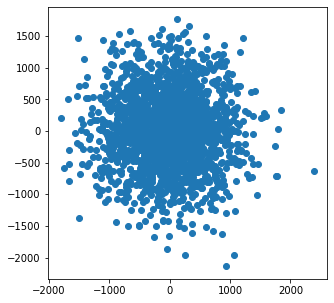

In [323]:
plt.figure(figsize=(5,5))
plt.scatter(x,y)

In [325]:
print(np.mean(kappa_perp[-1000:-1]))
print(np.mean(kappa_para[-1000:-1]))

1.7034109940342428
34.92461100362036


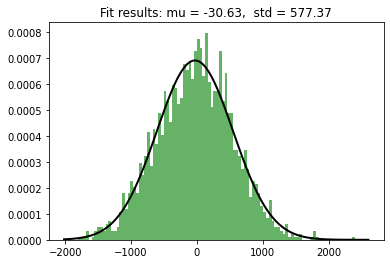

In [326]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = x
plt.figure()
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x_values = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_values, mu, std)
plt.plot(x_values, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()